Cut Sinyal

In [32]:
import pandas as pd
import glob
import os

# define the input directory containing the CSV files
input_dir = "D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/input"

# define the output directory for the split CSV files
output_dir = "D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/output"

# create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# get a list of all CSV files in the input directory
file_list = glob.glob(os.path.join(input_dir, '*.csv'))

# loop over each CSV file
for file_name in file_list:
    
    # load the CSV file into a pandas dataframe
    df = pd.read_csv(file_name)
    
    # divide the dataframe into parts with 10-second duration
    fs = 128
    duration = 30  # in seconds
    samples_per_duration = fs * duration
    n_samples = len(df)
    n_parts = n_samples // samples_per_duration
    remainder = n_samples % samples_per_duration

    for i in range(n_parts):
        start_idx = i * samples_per_duration
        end_idx = (i + 1) * samples_per_duration
        part_df = df[start_idx:end_idx]
        part_file_name = os.path.join(output_dir, f"{os.path.basename(file_name)[:-4]}_part{i+1}.csv")
        part_df.to_csv(part_file_name, index=False)
    
    # save the remainder as a separate file
    if remainder > 0:
        remainder_df = df[-remainder:]
        remainder_file_name = os.path.join(output_dir, f"{os.path.basename(file_name)[:-4]}_remainder.csv")
        remainder_df.to_csv(remainder_file_name, index=False)


Filtering

In [46]:
import os
import glob
import pandas as pd
import numpy as np
from scipy import signal

# Define bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=50):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    filter_coeffs = signal.firwin(order, [low, high], pass_zero=False)
    b = filter_coeffs
    a = 1
    return b, a

# Define function to apply filter to all channels of a dataframe
def apply_bandpass_filter(df, channels, lowcut, highcut, fs):
    b, a = butter_bandpass(lowcut, highcut, fs)
    for channel in channels:
        data = df[channel].values
        filtered_data = signal.filtfilt(b, a, data)
        df[channel] = filtered_data
    return df

# Set up parameters for bandpass filter
lowcut = 1 # lower cutoff frequency
highcut = 47 # upper cutoff frequency
fs = 128 # sampling frequency

# Set up directory path to CSV files
input_dir = "D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Sedang/output"
output_dir = "D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Sedang/filtered"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
file_list = glob.glob(os.path.join(input_dir, "*.csv"))

# Loop over all CSV files in directory and apply bandpass filter to all channels in each file
for filename in file_list:
    df = pd.read_csv(filename)
    channels_to_filter = list(df.columns) # use all columns as channels to filter
    df_filtered = apply_bandpass_filter(df, channels_to_filter, lowcut, highcut, fs)
    new_filename = os.path.basename(filename).split(".csv")[0] + "_filtered.csv" # create new filename for filtered data
    new_file_path=os.path.join(output_dir,new_filename)
    df_filtered.to_csv(new_file_path, index=False)


Plot Result

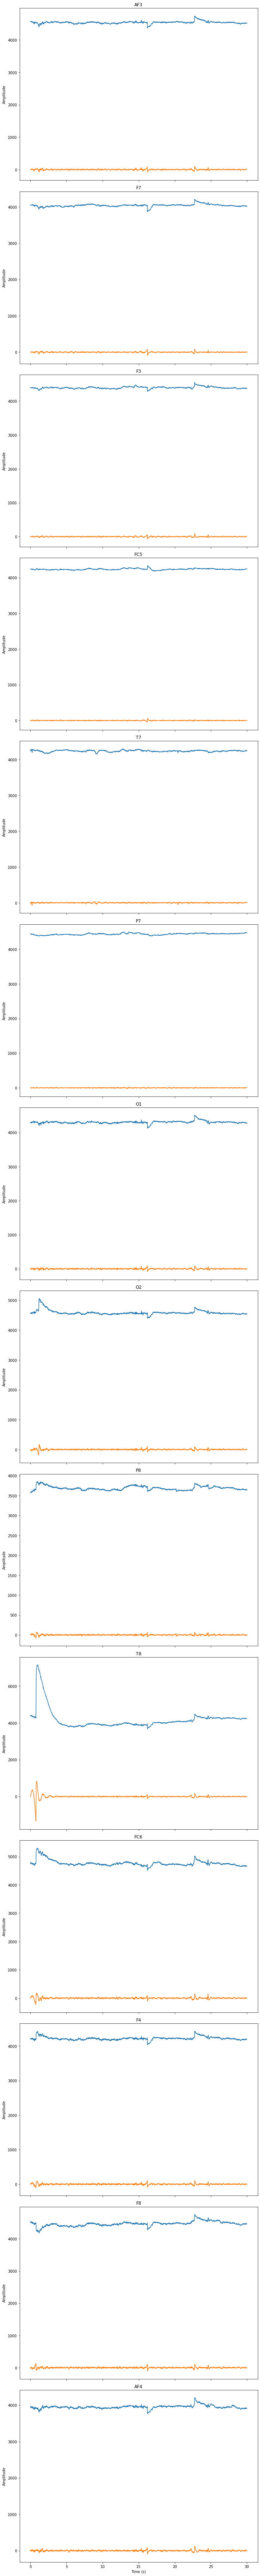

In [35]:
import os
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Define bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=1001):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    filter_coeffs = signal.firwin(order, [low, high], pass_zero=False)
    b = filter_coeffs
    a = 1
    return b, a

# Set up parameters for bandpass filter
lowcut = 1  # lower cutoff frequency
highcut = 47  # upper cutoff frequency
fs = 128  # sampling frequency

# Set up directory path to CSV files
input_dir = "D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/output"

# Select a file to process and plot
filename = "adit_part1.csv"  # Replace with the actual filename you want to process
file_path = os.path.join(input_dir, filename)

# Read the file into a dataframe
df = pd.read_csv(file_path)

# Get the channels to filter
channels_to_filter = list(df.columns)

# Apply bandpass filter to the selected channels
b, a = butter_bandpass(lowcut, highcut, fs)
filtered_data = signal.filtfilt(b, a, df.values, axis=0)
df_filtered = pd.DataFrame(filtered_data, columns=df.columns)

# Plot the original and filtered data for each channel
num_channels = len(channels_to_filter)
fig, axs = plt.subplots(num_channels, 1, figsize=(10, num_channels*7), sharex=True)

time = np.arange(len(df)) / fs

for i, channel in enumerate(channels_to_filter):
    axs[i].plot(time, df[channel], label=channel + " (Original)")
    axs[i].plot(time, df_filtered[channel], label=channel + " (Filtered)")
    axs[i].set_ylabel("Amplitude")
    axs[i].set_title(channel)

axs[-1].set_xlabel("Time (s)")
# plt.suptitle("Original and Filtered Data for Each Channel")
plt.tight_layout()
plt.show()


Band Power

In [47]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, welch
from pywt import wavedec


def extract_band_power(eeg_data, fs, band, level):
    # Apply wavelet decomposition with specified level
    coeffs = wavedec(eeg_data, 'db4', level=level)
    
    # Get the approximate coefficients of the specified level
    cA = coeffs[level]
    
    # Compute power spectral density (PSD) using Welch's method
    f, Pxx = welch(cA, fs, nperseg=min(256, len(cA)))
    
    # Define frequency bands
    freq_bands = {'delta': [0.5, 4],
                  'theta': [4, 8],
                  'alpha': [8, 13],
                  'beta': [13, 30],
                  'gamma': [30, 45]}
    
    # Define frequency indices
    freq_ix = {'delta': np.logical_and(f >= freq_bands['delta'][0], f < freq_bands['delta'][1]),
               'theta': np.logical_and(f >= freq_bands['theta'][0], f < freq_bands['theta'][1]),
               'alpha': np.logical_and(f >= freq_bands['alpha'][0], f < freq_bands['alpha'][1]),
               'beta': np.logical_and(f >= freq_bands['beta'][0], f < freq_bands['beta'][1]),
               'gamma': np.logical_and(f >= freq_bands['gamma'][0], f < freq_bands['gamma'][1])}
    
    # Calculate power in the specified band
    mask = freq_ix[band]
    band_power = np.trapz(y=Pxx[mask], x=f[mask])
    
    return band_power


# Define function to extract band powers for all channels in a single file
def extract_band_powers(filename):
    # Load CSV file
    df = pd.read_csv(filename)
    
    # Define sampling frequency and wavelet decomposition level
    fs = 128
    level = 4
    
    # Define list of channels to extract band powers from
    channels = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
    
    # Loop over all channels and frequency bands and compute band powers
    band_powers = {}
    for channel in channels:
        channel_powers = {}
        for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
            band_power = extract_band_power(df[channel].values, fs, band, level)
            channel_powers[band] = band_power
        band_powers[channel] = channel_powers
            
    return band_powers


# Set up directory paths
input_dir = "D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Sedang/filtered"
output_dir = "D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Sedang/power"

# Loop over all CSV files in directory and extract
channel_dfs = []
for filename in glob.glob(os.path.join(input_dir, "*.csv")):
    band_powers = extract_band_powers(filename)
    for channel in band_powers:
        channel_powers = band_powers[channel]
        channel_powers['channel'] = channel
        channel_powers['filename'] = os.path.basename(filename)
        channel_powers = pd.DataFrame.from_dict(channel_powers, orient='index').T
        channel_dfs.append(channel_powers)
df = pd.concat(channel_dfs)
df.to_csv(os.path.join(output_dir, 'band_powers.csv'), index=False)

Plotting Band Power

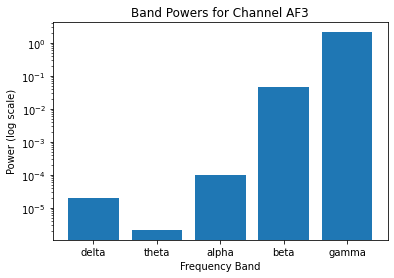

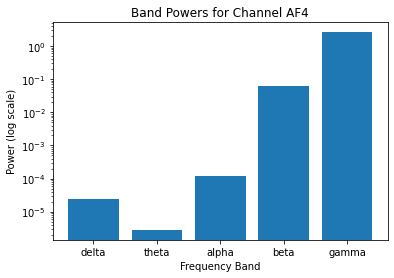

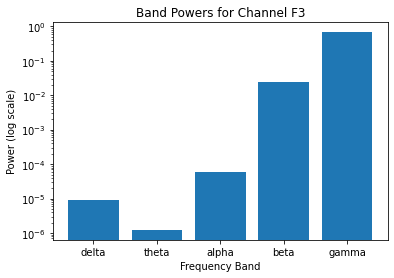

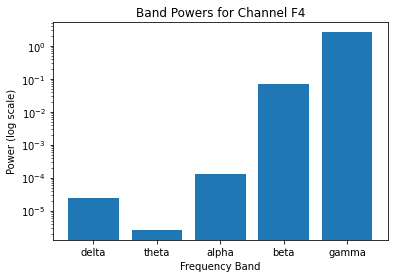

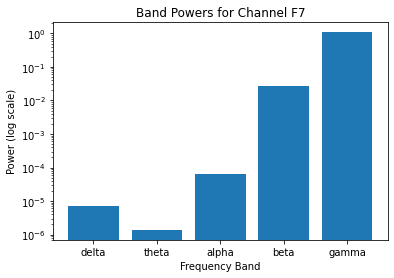

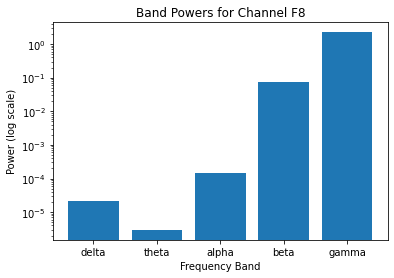

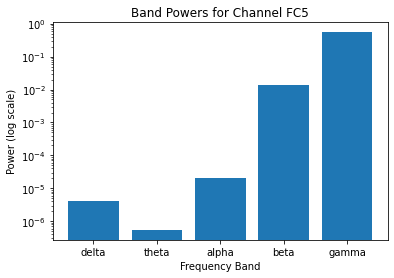

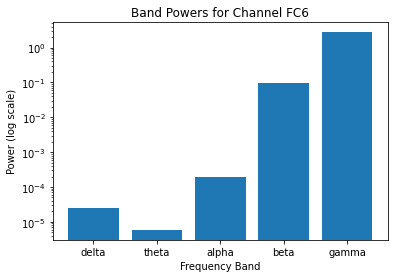

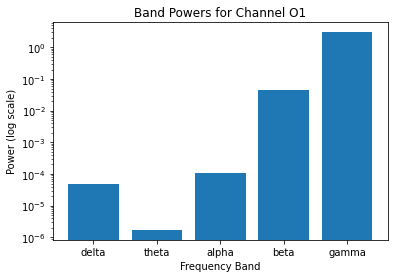

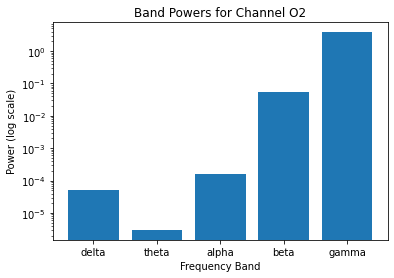

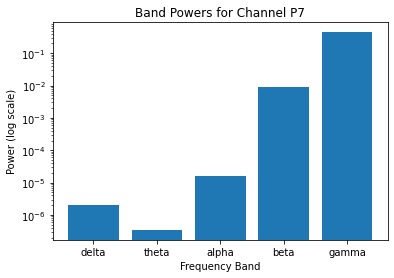

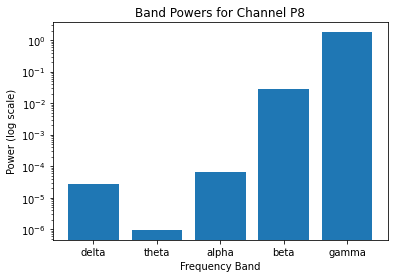

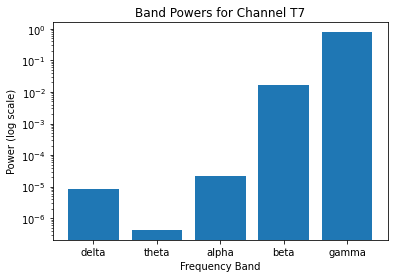

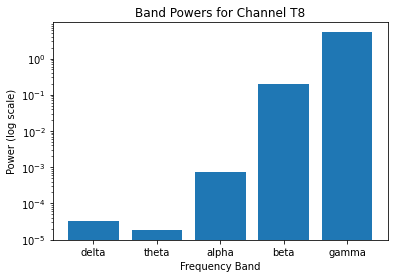

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import welch
from pywt import wavedec

# Load the band powers CSV file
# band_powers_df = pd.read_csv('D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/projek/Ringan/filtered/adit_part1_filtered.csv')

def extract_band_power(eeg_data, fs, band, level):
    # Apply wavelet decomposition with specified level
    coeffs = wavedec(eeg_data, 'db4', level=level)
    
    # Get the approximate coefficients of the specified level
    cA = coeffs[level]
    
    # Compute power spectral density (PSD) using Welch's method
    f, Pxx = welch(cA, fs, nperseg=min(256, len(cA)))
    
    # Define frequency bands
    freq_bands = {'delta': [0.5, 4],
                  'theta': [4, 8],
                  'alpha': [8, 13],
                  'beta': [13, 30],
                  'gamma': [30, 45]}
    
    # Define frequency indices
    freq_ix = {'delta': np.logical_and(f >= freq_bands['delta'][0], f < freq_bands['delta'][1]),
               'theta': np.logical_and(f >= freq_bands['theta'][0], f < freq_bands['theta'][1]),
               'alpha': np.logical_and(f >= freq_bands['alpha'][0], f < freq_bands['alpha'][1]),
               'beta': np.logical_and(f >= freq_bands['beta'][0], f < freq_bands['beta'][1]),
               'gamma': np.logical_and(f >= freq_bands['gamma'][0], f < freq_bands['gamma'][1])}
    
    # Calculate power in the specified band
    mask = freq_ix[band]
    band_power = np.trapz(y=Pxx[mask], x=f[mask])
    
    return band_power

def extract_band_powers(filename):
    # Load CSV file
    df = pd.read_csv(filename)
    
    # Define sampling frequency and wavelet decomposition level
    fs = 128
    level = 4
    
    # Define list of channels to extract band powers from
    channels = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
    
    # Loop over all channels and frequency bands and compute band powers
    band_powers = {}
    for channel in channels:
        channel_powers = {}
        for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
            band_power = extract_band_power(df[channel].values, fs, band, level)
            channel_powers[band] = band_power
        band_powers[channel] = channel_powers
            
    return band_powers


# Extract band powers from the CSV file
band_powers = extract_band_powers('D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/filtered/adit_part1_filtered.csv')


# Iterate over each channel
for channel in band_powers:
    # Get the frequency bands and their corresponding power values
    freq_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    powers = [max(band_powers[channel][band], 1e-10) for band in freq_bands]  # Add a small offset of 1e-10
    
    # Plot the band powers
    plt.figure()
    plt.bar(freq_bands, powers)
    plt.title(f"Band Powers for Channel {channel}")
    plt.xlabel("Frequency Band")
    plt.ylabel("Power (log scale)")
    plt.yscale('log')  # Apply logarithmic scale to the y-axis
    plt.show()




Statistical

In [48]:
#abis difilter langsung kesini sekaligus misah
import os
import glob
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# define function for feature extraction
def extract_features(data):
    # compute statistical features
    mean = np.mean(data)
    std = np.std(data)
    var = np.var(data)
    rms = np.sqrt(np.mean(np.square(data)))
    skewness = skew(data)
    kurt = kurtosis(data)
    # return features as dictionary
    features = {'mean': mean, 'std': std, 'var': var, 'rms': rms, 'skewness': skewness, 'kurtosis': kurt}
    return features

# specify paths to input and output folder
input_folder = "D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Sedang/filtered"
output_folder ="D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Sedang/statistical"

# get list of CSV files in input folder
files = glob.glob(os.path.join(input_folder, '*.csv'))

# process each file in the list
for file in files:
    # load data from CSV file
    df = pd.read_csv(file)
    # get channel names from data frame columns
    channels = df.columns.tolist()
    # process each channel
    for channel in channels:
        # select data for the current channel
        data = df[channel].values
        # extract features
        features = extract_features(data)
        # create output folder for the current channel
        channel_folder = os.path.join(output_folder, channel)
        if not os.path.exists(channel_folder):
            os.makedirs(channel_folder)
        # create output file name based on input file name
        output_file = os.path.join(channel_folder, os.path.basename(file).replace('.csv', '_{}_features.csv'.format(channel)))
        # save features to output file
        pd.DataFrame(features, index=[0]).to_csv(output_file, index=False)


Print Dataframe statistical

In [21]:
import pandas as pd
import glob

# Get a list of all csv files in a directory
file_list = glob.glob('D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/statistical/FC5/*.csv')

# Create an empty list to store dataframes
df_list = []

# Loop through each file and read it into a dataframe
for file in file_list:
    df = pd.read_csv(file)
    df_list.append(df)

# Concatenate all dataframes into a single dataframe
merged_df = pd.concat(df_list, axis=0, ignore_index=True)
merged_df


,mean,std,var,rms,skewness,kurtosis
0,1517.737206,7.887270,62.209026,1517.757700,0.105745,0.157188
1,1523.738772,8.687497,75.472607,1523.763537,2.827230,16.983941
2,1525.220822,6.169057,38.057264,1525.233297,0.167034,0.416418
3,1536.285888,10.856984,117.874095,1536.324251,0.373533,-0.208920
4,1528.273652,7.451098,55.518868,1528.291816,0.122140,0.767276
...,...,...,...,...,...,...
210,1556.110491,53.499709,2862.218860,1557.029891,0.428916,1.551102
211,1561.357269,35.351079,1249.698754,1561.757414,0.083943,1.559849
212,1513.936073,49.923485,2492.354348,1514.758986,-0.766213,-0.735360
213,1556.292327,15.605853,243.542662,1556.370570,-0.207248,-0.447291


In [41]:
## PAKE INI BUAT MERGED
import pandas as pd
import glob

def merge_csv_files(input_folder, output_file):
    # Get a list of all csv files in the input folder
    file_list = glob.glob(input_folder + '/*.csv')

    # Create an empty list to store dataframes
    df_list = []

    # Loop through each file and read it into a dataframe
    for file in file_list:
        df = pd.read_csv(file)
        df_list.append(df)

#     Concatenate all dataframes into a single dataframe
    merged_df = pd.concat(df_list, axis=0, ignore_index=True)

    # Save merged dataframe to output file
    merged_df.to_csv(output_file, index=False)

# Specify input and output file paths
input_folder = 'D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/statistical/FC5'
output_file = 'D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/dataframe/FC5/merged_statistical.csv'

# Call function to merge CSV files
merge_csv_files(input_folder, output_file)


In [66]:
import pandas as pd
import glob

# Get a list of all csv files in a directory
file_list = glob.glob('D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Sedang/statistical/FC6/*.csv')

# Create an empty list to store dataframes
df_list = []

# Loop through each file and read it into a dataframe
for file in file_list:
    df = pd.read_csv(file)
    df_list.append(df)

# Concatenate all dataframes into a single dataframe
merged_df = pd.concat(df_list, axis=0, ignore_index=True)

# Save the merged dataframe to a new CSV file
output_file = 'D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/dataframe/FC6/merged1_statistical.csv'
merged_df.to_csv(output_file, index=False)

# Print the merged dataframe
print(merged_df)


           mean        std          var          rms  skewness   kurtosis
0   1665.148498  55.525966  3083.132943  1666.074024 -1.653735   2.973526
1   1676.112313  33.827088  1144.271903  1676.453625 -0.821355   2.922362
2   1677.192575  35.815603  1282.757426  1677.574943  0.019908   1.696389
3   1678.288544  26.212452   687.092614  1678.493232 -0.619406   3.908939
4   1683.881134  43.805537  1918.925112  1684.450830  2.319491  20.808298
..          ...        ...          ...          ...       ...        ...
69  1707.927573  19.220064   369.410860  1708.035715  0.057102   0.405665
70  1715.841185  21.510768   462.713130  1715.976015  0.336446   0.296911
71  1712.366836  19.968265   398.731596  1712.483259 -0.054101   0.298151
72  1711.369222  16.539950   273.569940  1711.449147  0.081828   0.217014
73  1703.380184  26.594958   707.291791  1703.587785 -1.580511   3.780535

[74 rows x 6 columns]


Entropy

In [51]:
import numpy as np
import scipy.signal as signal
import os

# Set the input and output directories
input_dir = 'D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Sedang/filtered'
output_dir = 'D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Sedang/entropy/'

# Set the window size (in samples)
win_size = 256

# Loop over all the files in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith('.csv'):  # Adjust this if your files have a different extension
        # Load the EEG signal from the file
        eeg_data = np.loadtxt(os.path.join(input_dir, filename), delimiter=',',skiprows=1)

        # Loop over all the channels in the EEG signal
        for channel_idx in range(eeg_data.shape[1]):
            # Extract the current channel's data
            channel_data = eeg_data[:, channel_idx]

            # Calculate the power spectral density of the channel's data
            f, psd = signal.welch(channel_data, fs=128, window='hann', nperseg=win_size, noverlap=win_size//2)

            # Normalize the PSD
            norm_psd = psd / np.sum(psd)

            # Calculate the Shannon entropy of the normalized PSD
            entropy = -np.sum(norm_psd * np.log2(norm_psd)) / np.log2(norm_psd.size)

            # Save the entropy value to a file
            channel_name = f'channel_{channel_idx+1}'
            output_path = os.path.join(output_dir, channel_name)
            if not os.path.exists(output_path):
                os.makedirs(output_path)
            output_filename = os.path.splitext(filename)[0] + '_' + channel_name + '.csv'
            output_file = os.path.join(output_path, output_filename)
            np.savetxt(output_file, [entropy], delimiter=',')


Plot Hasil Entropy

In [55]:
import numpy as np
import scipy.signal as signal
import os
import pandas as pd

# Set the input and output directories
input_dir = 'D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/filtered'
output_dir = 'D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Ringan/entropy/'

# Set the window size (in samples)
win_size = 256

# Initialize a list to store the entropy values
entropy_list = []

# Loop over all the files in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith('.csv'):  # Adjust this if your files have a different extension
        # Load the EEG signal from the file
        eeg_data = np.loadtxt(os.path.join(input_dir, filename), delimiter=',', skiprows=1)

        # Loop over all the channels in the EEG signal
        for channel_idx in range(eeg_data.shape[1]):
            # Extract the current channel's data
            channel_data = eeg_data[:, channel_idx]

            # Calculate the power spectral density of the channel's data
            f, psd = signal.welch(channel_data, fs=128, window='hann', nperseg=win_size, noverlap=win_size // 2)

            # Normalize the PSD
            norm_psd = psd / np.sum(psd)

            # Calculate the Shannon entropy of the normalized PSD
            entropy = -np.sum(norm_psd * np.log2(norm_psd)) / np.log2(norm_psd.size)

            # Append the entropy value to the list
            entropy_list.append(entropy)

# Create a dataframe from the entropy list
df = pd.DataFrame({'Entropy': entropy_list})

# Print the dataframe
print(df)


      Entropy
0    0.787068
1    0.768751
2    0.772388
3    0.817065
4    0.566334
..        ...
975  0.498984
976  0.514455
977  0.512028
978  0.509945
979  0.514105

[980 rows x 1 columns]


Buat Gabung hasil entropy

In [69]:
import pandas as pd
import glob

# Get a list of all csv files in a directory
file_list = glob.glob('D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/Sedang/entropy/channel_11/*.csv')

# Create an empty dataframe
merged_df = pd.DataFrame()

# Loop through each file and read it into a dataframe
for file in file_list:
    df = pd.read_csv(file)
    merged_df = pd.concat([merged_df, df], axis=0)

# Reset the index of the merged dataframe
merged_df = merged_df.reset_index(drop=True)

# Save the merged dataframe to a new CSV file
output_file = 'D:/one drive UA/OneDrive - Universitas Airlangga/SEMESTER 6/ASB/demo/dataframe/FC6/merged1_entropy.csv'
merged_df.to_csv(output_file, index=False)

# Print the merged dataframe
print(merged_df)


Empty DataFrame
Columns: [6.239868103918225772e-01, 6.688565216853481488e-01, 5.926443395649452217e-01, 7.161139447434482497e-01, 5.880990068202900378e-01, 4.849468673971679689e-01, 7.057807273147234106e-01, 3.625034194987574732e-01, 6.957244699358511308e-01, 5.924235996940132587e-01, 5.060945711296740424e-01, 4.158355791787858302e-01, 5.654809219648446739e-01, 5.632096088692922775e-01, 6.880128104370254460e-01, 8.362280849606981148e-01, 4.693136881225166146e-01, 4.508821784723112680e-01, 8.134518296950847827e-01, 6.444000759249126631e-01, 6.023549316240450757e-01, 6.973509763351757318e-01, 8.482679367163535877e-01, 4.559191603415370664e-01, 2.543341462246887508e-01, 8.326416075290492547e-01, 6.338595223063940853e-01, 8.487396523892472011e-01, 7.130458902472716076e-01, 7.538949692296910143e-01, 7.638645210446669553e-01, 7.187461900060462261e-01, 8.393925274444261619e-01, 8.029311958530929161e-01, 7.969084901491086947e-01, 7.329448232276545294e-01, 7.533931268593075936e-01, 6.7264555004

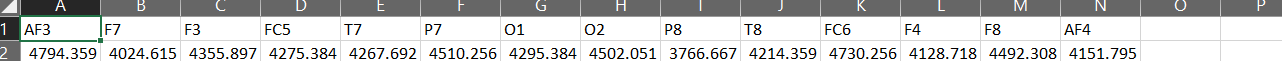